In [1]:
import ROOT as rt
import root_numpy as rtnp
import csv
import re
import sys
import uproot
import numpy as np
import awkward
import math
import numba
import scipy.stats

from matplotlib import pyplot as plt
sys.path.append('/nfshome/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph
from array import array
#from prettytable import PrettyTable
import collections
from collections import OrderedDict
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

# donotdelete = []


Welcome to JupyROOT 6.18/00


In [38]:
directory = '/mnt/hadoop/store/group/phys_exotica/jmao/jet_timing_studies/samples_plus/signal/bbbb/ggh/'
out_dir = '/nfshome/jmao/cms-llp/plots/20190719/'
name_string1 = 'ntuple_RunIISummer16_'
name_string2 = '.root'

labels = {'bbbb_ggh_mh125_mx50_pl10000',
          'bbbb_ggh_mh125_mx50_pl1000',
          'bbbb_ggh_mh2000_mx975_pl1000'}

texs = {}

texs['bbbb_ggh_mh125_mx50_pl10000'] = 'm_{h} = 125 GeV, m_{x} = 50 GeV, c#tau = 10m'
texs['bbbb_ggh_mh125_mx50_pl1000'] = 'm_{h} = 125 GeV, m_{x} = 50 GeV, c#tau = 1m'
texs['bbbb_ggh_mh2000_mx975_pl1000'] = 'm_{h} = 2000 GeV, m_{x} = 975 GeV, c#tau = 1m'

cols = {}

cols['bbbb_ggh_mh125_mx50_pl10000'] =  1
cols['bbbb_ggh_mh125_mx50_pl1000'] =  2
cols['bbbb_ggh_mh2000_mx975_pl1000'] = 4 


MODEL = 'pp #rightarrow XX, X #rightarrow bb, X #rightarrow bb, ggH'

fpath = OrderedDict()
tree = OrderedDict()
nevts = OrderedDict()

 

for label in labels:
    print(label)
    fpath[label] = directory + name_string1 + label + name_string2
    print (label, fpath[label])

    print ('File ready')


    root_dir = uproot.open(fpath[label]) 
    print ('Open ready')

    tree[label] = root_dir['ntuples/llp']
    print ('Tree ready')

    nevts[label] = root_dir['ntuples/NEvents'][1]
    print ('NEvents = ', nevts[label])
    print ('NEvents ready')


bbbb_ggh_mh125_mx50_pl1000
bbbb_ggh_mh125_mx50_pl1000 /mnt/hadoop/store/group/phys_exotica/jmao/jet_timing_studies/samples_plus/signal/bbbb/ggh/ntuple_RunIISummer16_bbbb_ggh_mh125_mx50_pl1000.root
File ready
Open ready
Tree ready
NEvents =  50918.0
NEvents ready
bbbb_ggh_mh125_mx50_pl10000
bbbb_ggh_mh125_mx50_pl10000 /mnt/hadoop/store/group/phys_exotica/jmao/jet_timing_studies/samples_plus/signal/bbbb/ggh/ntuple_RunIISummer16_bbbb_ggh_mh125_mx50_pl10000.root
File ready
Open ready
Tree ready
NEvents =  50973.0
NEvents ready
bbbb_ggh_mh2000_mx975_pl1000
bbbb_ggh_mh2000_mx975_pl1000 /mnt/hadoop/store/group/phys_exotica/jmao/jet_timing_studies/samples_plus/signal/bbbb/ggh/ntuple_RunIISummer16_bbbb_ggh_mh2000_mx975_pl1000.root
File ready
Open ready
Tree ready
NEvents =  17362.0
NEvents ready


In [39]:
#sort lists based on list1 and require list1 to be valid
def sort_valid_lists(list1, list2): 
    list3 = []
    for index, (ele1,ele2) in enumerate(zip(list1,list2)): 
#         print(index,ele1,ele2)
        if not math.isnan(ele1):
#             print("ele1 is not nan")
            list3.append(tuple((ele1,ele2)))
    list3.sort(key=lambda x: x[0])
    return list3 

# Smear jet time cut

In [40]:
cases = ['EB only', 'ETL only', 'EB or ETL']
# print(cases,cases[0])
for i,j in enumerate(cases):
    print(i,j)

0 EB only
1 ETL only
2 EB or ETL


In [41]:
t_cuts = [-5.,-4.,-3.,-2.,-1.,-0.8,-0.6,-0.4,-0.2,0.,0.2,0.4,0.6,0.8,1.,2.,3.,4.,5.]
print(len(t_cuts))
sigma = [0.193]
print(len(sigma))
print(len(tree))
ntr = len(tree)

i=0

Firsts = []
Seconds = []

Pt_maxes = []
Pt_seconds = []

# loop over events and get an array of maximum jet time in events
for k,v in tree.items():   

#         print(i, k, v)
    BSTime = v['genVertexT'].array()
    weight = v['genWeight'].array()
    
    Firsts_tree = []
    Seconds_tree = []

    Pt_maxes_tree = []
    Pt_seconds_tree = []

    for case_i,case in enumerate(cases):
        if case == 'EB only':
            jetPt = v['gLLP_daughter_pt'].array()
            jetEta = v['gLLP_daughter_eta'].array()
            jetGenTime = v['gen_time'].array()
        elif case == 'ETL only':
            jetPt = v['gLLP_daughter_pt'].array()
            jetEta = v['gLLP_daughter_eta'].array()
            jetGenTime = v['gen_time_ETL'].array()
        elif case == 'EB or ETL':
            jetPt_EB = v['gLLP_daughter_pt'].array()
            jetPt_ETL = v['gLLP_daughter_pt'].array()
            jetPt = np.concatenate((jetPt_EB, jetPt_ETL), axis=1) 
            
            jetEta_EB = v['gLLP_daughter_eta'].array()
            jetEta_ETL = v['gLLP_daughter_eta'].array()
            jetEta = np.concatenate((jetEta_EB, jetEta_ETL), axis=1) 

            jetGenTime_EB = v['gen_time'].array()
            jetGenTime_ETL = v['gen_time_ETL'].array()
            jetGenTime = np.concatenate((jetGenTime_EB, jetGenTime_ETL), axis=1) 

        jetTime = [x-y for x,y in zip(jetGenTime,BSTime)]
    
#     print(jetGenTime[0],BSTime[0], jetTime[0])\

        jetPt = np.array(jetPt)
    
        maxes = jetPt[:,0]
        seconds = jetPt[:,1]
 
    
        maxes = np.array(maxes)
        seconds = np.array(seconds)

        for j,sig in enumerate(sigma):
    #     for j,sig in enumerate(sigma):
    #         print(j,sig)
            n = i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
    #         print('n',n)
            print(i, j, n,m,len(weight))
            SmearTime = np.random.normal(0,sig,len(BSTime))
            jetNewTime = [x+y for x,y in zip(jetTime,SmearTime)]
    #         print(jetTime[0],SmearTime[0], jetNewTime[0])    


            jetTime_most_delayed = []
            jetTime_second_delayed = []
            
            print(k,i,case_i,case)
            
 
            for evt, (time, pt) in enumerate(zip(jetNewTime,jetPt)):
        #         print(i,time,pt,len(time),len(pt))
                time_s =[]
                pt_s= []
                for par in range(len(time)):
        #             print(j,pt[j])
                    time_s.append(time[par])
                    pt_s.append(pt[par])
        #         print(i,time_s)
        #         print(i,pt_s)
                validpairlist = sort_valid_lists(time_s,pt_s)
        #         print(i,validpairlist)
        #         print(validpairlist[-1][0])
                if len(validpairlist)>1 :
        #             print(i,len(validpairlist))
        #             print(i,validpairlist[-1][0],validpairlist[-2][0])
                    jetTime_most_delayed.append(validpairlist[-1][0])
                    jetTime_second_delayed.append(validpairlist[-2][0])
                else:
                    jetTime_most_delayed.append(-666)
                    jetTime_second_delayed.append(-666)
    #             if i>2:
    #                 break
            jetTime_most_delayed = np.array(jetTime_most_delayed)
            jetTime_second_delayed = np.array(jetTime_second_delayed)
            print(i,k,case_i,case,len(jetTime_most_delayed),len(jetTime_second_delayed),len(maxes),len(seconds))
            
            tcut666_string1 = np.logical_and( jetTime_most_delayed, jetTime_most_delayed>-600)
            tcut666_string = np.logical_and( jetTime_most_delayed>-600, jetTime_second_delayed>-600)
            
            weight1_cut666 = jetTime_most_delayed[tcut666_string1]
            weight_cut666 = jetTime_most_delayed[tcut666_string]
            
            Ntotal_1j = np.shape(weight1_cut666)[0]        
            Ntotal_2j = np.shape(weight_cut666)[0]  
            print(i,k,case_i,case, Ntotal_1j, Ntotal_2j)
    
#             Firsts.append(jetTime_most_delayed)
#             Seconds.append(jetTime_second_delayed)
            
            Firsts_tree.append(jetTime_most_delayed)
            Seconds_tree.append(jetTime_second_delayed)
#             print(k,case)
#     print(k,i,case,Firsts_case)
    #         print(n,'found max jet gen time')
    Firsts_tree = np.array(Firsts_tree)
    Seconds_tree = np.array(Seconds_tree)
    print(len(Firsts_tree),len(Seconds_tree))
        
    Firsts.append(Firsts_tree)
    Seconds.append(Seconds_tree)    
    
    Pt_maxes.append(maxes)
    Pt_seconds.append(seconds)

    i += 1
    
# Firsts = np.array(Firsts_tree)
# Seconds = np.array(Seconds_tree)
# print('found max, second jet gen time')
print(len(Firsts),len(Seconds))
print(len(Firsts[0]),len(Seconds[0]))

Pt_maxes = np.array(Pt_maxes)
Pt_seconds = np.array(Pt_seconds)
print('found max second Pts', len(Pt_maxes),len(Pt_seconds))


19
1
3
0 0 0 0 50918
bbbb_ggh_mh125_mx50_pl1000 0 0 EB only
0 bbbb_ggh_mh125_mx50_pl1000 0 EB only 50918 50918 50918 50918
0 bbbb_ggh_mh125_mx50_pl1000 0 EB only 34705 26092
0 0 0 1 50918
bbbb_ggh_mh125_mx50_pl1000 0 1 ETL only
0 bbbb_ggh_mh125_mx50_pl1000 1 ETL only 50918 50918 50918 50918
0 bbbb_ggh_mh125_mx50_pl1000 1 ETL only 24488 9837
0 0 0 2 50918
bbbb_ggh_mh125_mx50_pl1000 0 2 EB or ETL
0 bbbb_ggh_mh125_mx50_pl1000 2 EB or ETL 50918 50918 50918 50918
0 bbbb_ggh_mh125_mx50_pl1000 2 EB or ETL 42192 38367
3 3
1 0 1 3 50973
bbbb_ggh_mh125_mx50_pl10000 1 0 EB only
1 bbbb_ggh_mh125_mx50_pl10000 0 EB only 50973 50973 50973 50973
1 bbbb_ggh_mh125_mx50_pl10000 0 EB only 10074 6973
1 0 1 4 50973
bbbb_ggh_mh125_mx50_pl10000 1 1 ETL only
1 bbbb_ggh_mh125_mx50_pl10000 1 ETL only 50973 50973 50973 50973
1 bbbb_ggh_mh125_mx50_pl10000 1 ETL only 5105 1469
1 0 1 5 50973
bbbb_ggh_mh125_mx50_pl10000 1 2 EB or ETL
1 bbbb_ggh_mh125_mx50_pl10000 2 EB or ETL 50973 50973 50973 50973
1 bbbb_ggh_mh125_m

In [42]:
print(len(Firsts),len(Seconds))
print(len(Firsts[0]),len(Seconds[0]))
print(len(Firsts[1]),len(Seconds[1]))
print(len(Firsts[2]),len(Seconds[2]))

3 3
3 3
3 3
3 3


In [43]:
i = 0
Power_1j = []
Power_2j = []

for k,v in tree.items():   
    print(k, v)
#     jetGenTime = v['gen_time'].array()
    weight = v['genWeight'].array()

    Power_1j_tree = []
    Power_2j_tree = []

    for case_i,case in enumerate(cases):
        print(case_i,case)

        for j,sig in enumerate(sigma):
            print(j,sig)

            Power_eff_1j = []
            Power_eff_2j = []

            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            print('n,s,m',n,s,m)
    #         print(i,j,n,len(weight))

            jetGenTime_max = Firsts[i][s] 
            jetGenTime_second = Seconds[i][s] 
            print(len(weight),len(jetGenTime_max),len(jetGenTime_second))

 
    
    i += 1
    
 

bbbb_ggh_mh125_mx50_pl1000 <TTree b'llp' at 0x7f3781f86b38>
0 EB only
0 0.193
n,s,m 0 0 0
50918 50918 50918
1 ETL only
0 0.193
n,s,m 0 1 1
50918 50918 50918
2 EB or ETL
0 0.193
n,s,m 0 2 2
50918 50918 50918
bbbb_ggh_mh125_mx50_pl10000 <TTree b'llp' at 0x7f3781a8ca20>
0 EB only
0 0.193
n,s,m 1 0 3
50973 50973 50973
1 ETL only
0 0.193
n,s,m 1 1 4
50973 50973 50973
2 EB or ETL
0 0.193
n,s,m 1 2 5
50973 50973 50973
bbbb_ggh_mh2000_mx975_pl1000 <TTree b'llp' at 0x7f37814bfb70>
0 EB only
0 0.193
n,s,m 2 0 6
17362 17362 17362
1 ETL only
0 0.193
n,s,m 2 1 7
17362 17362 17362
2 EB or ETL
0 0.193
n,s,m 2 2 8
17362 17362 17362


In [44]:
# thre = np.array(range(1000))/100.0-5  #-5 to 5 time thresholds
# thre = [0,0.5,1,5]
# thre = np.array(thre)

# # print(thre)

# rej = []

# for t in thre:
#     rej.append(1/scipy.stats.norm.sf(t,0,0.22))
    
# rej = np.array(rej)
# print(rej)


In [45]:
Lumi = 5 * 1e-34 #cm^-2 s^-1
Xsec = 1e+8 * 1e-9 * 1e-24 #cm^-2 1e+8 nb
Time = 10 * 1e-6 #sec, 12.5 us 
Nexp = Lumi*Xsec*Time
print(Nexp)

4.999999999999999e-64


In [46]:
Nexp = 30*1e+06
print(Nexp)

30000000.0


In [47]:
thre = np.array(range(1000))/100.0-5  #-5 to 5 time thresholds
# thre = [0,0.5]
# thre = np.array(thre)

# print(thre)

rej = []

for t in thre:
#     print(t)
#     if t>-4.8:
#         break
    power = scipy.stats.norm.sf(t,0,0.22)
#     power = 1/scipy.stats.norm.sf(t,0,0.22)
#     if power > Nexp:
#         power = Nexp
    rej.append(power)
    
rej = np.array(rej)
# print(rej)


In [48]:
#effs 
eff_1j = {}
eff_2j = {}

pt_cuts = [0,20,30,40,50,60]


i = 0

print('i,j,n,s,m,a')
print('tree,sig,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

    weight = v['genWeight'].array()

    jetPt_max = Pt_maxes[i]
    jetPt_second = Pt_seconds[i] 

    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
            
            jetGenTime_max = Firsts[i][case_i] 
            jetGenTime_second = Seconds[i][case_i] 
            print(i,k,case_i,case)
#             print(len(jetGenTime_max),len(jetGenTime_second))
            
            tcut666_string1 = np.logical_and( jetGenTime_max, jetGenTime_max>-600)
            tcut666_string = np.logical_and( jetGenTime_second>-600, jetGenTime_max>-600)
            
            weight1_cut666 = weight[tcut666_string1]
            weight_cut666 = weight[tcut666_string]
            
            Ntotal_1j = np.shape(weight1_cut666)[0]        
            Ntotal_2j = np.shape(weight_cut666)[0]  
            
            print('case',case,'Ntotal',Ntotal_1j, Ntotal_2j)
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                ptcut_string1 = np.logical_and( jetPt_max > pt, jetPt_max>-600)
                ptcut_string2 = np.logical_and( jetPt_second > pt, jetPt_second>-600)
                ptcut_string = np.logical_and( ptcut_string1, ptcut_string2)
                
                cut666_string = np.logical_and( ptcut_string, tcut666_string)
                cut666_string1 = np.logical_and( ptcut_string1, tcut666_string1)
                
#                 weight1_cut666 = weight[cut666_string1]
#                 weight_cut666 = weight[cut666_string]

#                 Ntotal_1j = np.shape(weight1_cut666)[0]        
#                 Ntotal_2j = np.shape(weight1_cut666)[0]        
# #                 Ntotal_2j = np.shape(weight_cut666)[0]  
#                 print('case',case,'pt',pt,'Ntotal',Ntotal_1j, Ntotal_2j)

                eff_1j[a] = []
                eff_2j[a] = []
    
                cnt = 0
            
                
                for t in thre:
                    
#                     print(t)
                    
                    tcut_string1 = np.logical_and( jetGenTime_max > t, jetGenTime_max>-600)
                    tcut_string2 = np.logical_and( jetGenTime_second > t, jetGenTime_second>-600)
                    tcut_string = np.logical_and( tcut_string1, tcut_string2)
                    
                    cut_string = np.logical_and( ptcut_string, tcut_string)
                    cut_string1 = np.logical_and( ptcut_string1, tcut_string1)
#                     cut_string2 = np.logical_and( ptcut_string2, tcut_string2)
                    
                    cutted_w_v = weight[cut_string]
                    cutted_w1_v = weight[cut_string1]
#                     cutted_w2_v = weight[cut_string2]
                    
                    Nsel_1j =  np.shape(cutted_w1_v)[0]
                    Nsel_2j =  np.shape(cutted_w_v)[0]
            
#                     if Nsel_1j == Nsel_2j and cnt==0:
#                         print('NO YAY!')
#                         print(k,case,pt)
#                         cnt += 1
                  
                    eff_1j[a].append(Nsel_1j/Ntotal_1j)
                    eff_2j[a].append(Nsel_2j/Ntotal_2j)
                    
                eff_1j[a] = np.array(eff_1j[a])
                eff_2j[a] = np.array(eff_2j[a])
                
#                 print(len(eff_1j[a]),len(eff_2j[a]))
                              
                    
    i += 1

i,j,n,s,m,a
tree,sig,n,s,m,a
0 bbbb_ggh_mh125_mx50_pl1000 0 EB only
case EB only Ntotal 34705 26092
0 bbbb_ggh_mh125_mx50_pl1000 1 ETL only
case ETL only Ntotal 24488 9837
0 bbbb_ggh_mh125_mx50_pl1000 2 EB or ETL
case EB or ETL Ntotal 42192 38367
1 bbbb_ggh_mh125_mx50_pl10000 0 EB only
case EB only Ntotal 10074 6973
1 bbbb_ggh_mh125_mx50_pl10000 1 ETL only
case ETL only Ntotal 5105 1469
1 bbbb_ggh_mh125_mx50_pl10000 2 EB or ETL
case EB or ETL Ntotal 12225 10796
2 bbbb_ggh_mh2000_mx975_pl1000 0 EB only
case EB only Ntotal 17233 16502
2 bbbb_ggh_mh2000_mx975_pl1000 1 ETL only
case ETL only Ntotal 7000 1879
2 bbbb_ggh_mh2000_mx975_pl1000 2 EB or ETL
case EB or ETL Ntotal 17328 17249


In [49]:
print(len(eff_1j),len(eff_2j))
# print(eff_1j[0])

54 54


In [50]:
print(len(eff_1j[0]))
print(len(eff_2j[0]))

print(eff_1j[30][600])
print(eff_2j[30][600])
# for i in range(1000):
#     print(eff_1j[0][i],eff_2j[0][i])


1000
1000
0.6350102249488753
0.5337161911819193


i,j,n,s,m,a
bbbb_ggh_mh125_mx50_pl10000


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


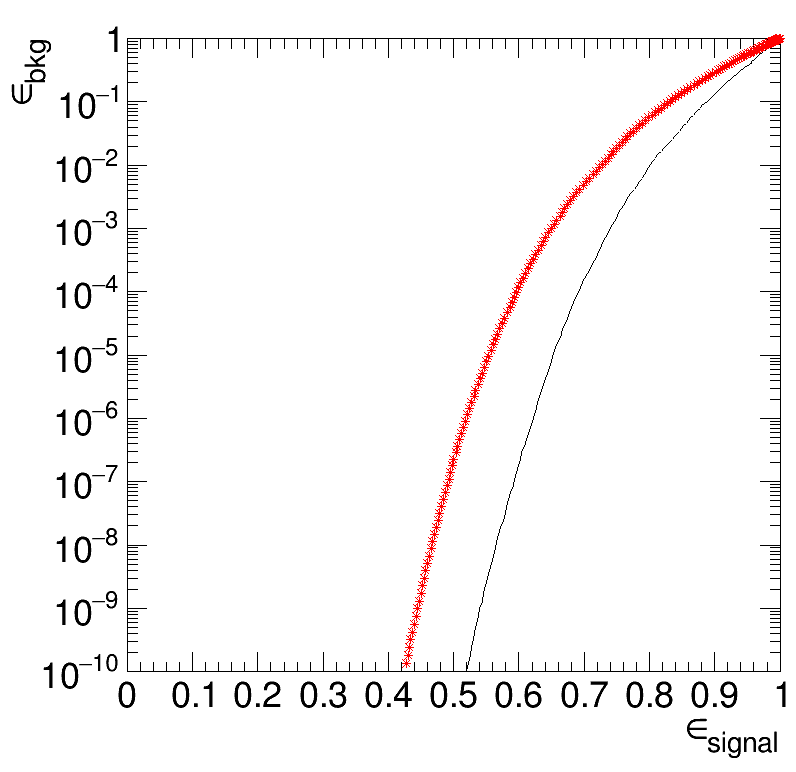

In [51]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.94)
leg.SetTextSize(0.022)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
            
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                
#                 gr_1j[a].SetLineColor(std_color_list[i])
#                 gr_1j[a].SetLineWidth(2)
#                 gr_1j[a].SetMarkerColor(std_color_list[i])
#                 leg.AddEntry(gr_1j[a],str(a))

#                 gr_1j[a].Draw('ac' if i==0 else 'csame')
                if a ==30:
                    print(k)
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
                    gr_2j[a].SetMarkerColor(2)
#                     gr_2j[a].SetMarkerStyle(2)
#                     gr_2j[a].SetMarkerSize(0.5)
#                     gr_2j[a].SetLineColor(2)
                    gr_2j[a].Draw('*same')
#                 else:
#                     gr_1j[a].Draw('csame')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
    i += 1

# leg.Draw()

c.SetLogy()
c.Update()
c.Draw()


i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl1000_EB_only_1j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl1000_ETL_only_1j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl1000_EB_or_ETL_1j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl10000_EB_only_1j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshom

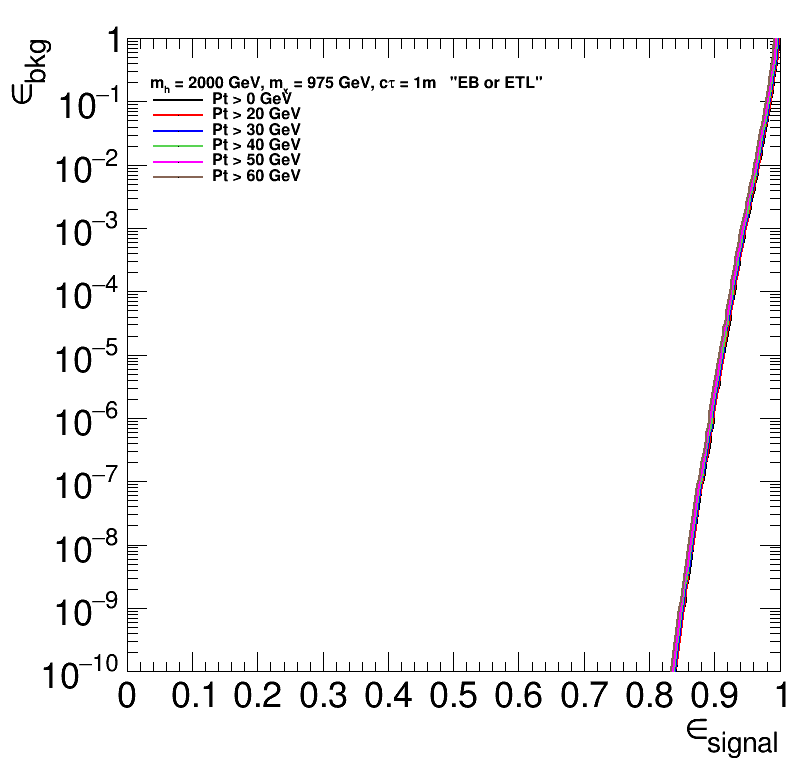

In [52]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
            c = rt.TCanvas('c','c', 800, 800)
            leg = rt.TLegend(0.18,0.76,0.53,0.90)
            leg.SetTextSize(0.022)
            leg.SetBorderSize(0)
            leg.SetFillStyle(0)
            leg.SetEntrySeparation(0.01)            
            leg.SetHeader(texs[k]+'   "'+case+'"')            
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[p])
                
                if p==0:
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
                    leg.AddEntry(gr_1j[a],'Pt > '+str(pt)+' GeV')            
                else:
                    gr_1j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'Pt > '+str(pt)+' GeV')            
                    
            leg.Draw()

            c.SetLogy()
            c.Update()
            c.Draw()
            c.SaveAs(out_dir+'Roc_'+k+'_'+case.replace(' ','_')+'_1j.png')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
    i += 1

# leg.Draw()

# c.SetLogy()
# c.Update()
# c.Draw()
# c.SaveAs(out_dir+'Roc_.png')

i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl1000_EB_only_2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl1000_ETL_only_2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl1000_EB_or_ETL_2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl10000_EB_only_2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshom

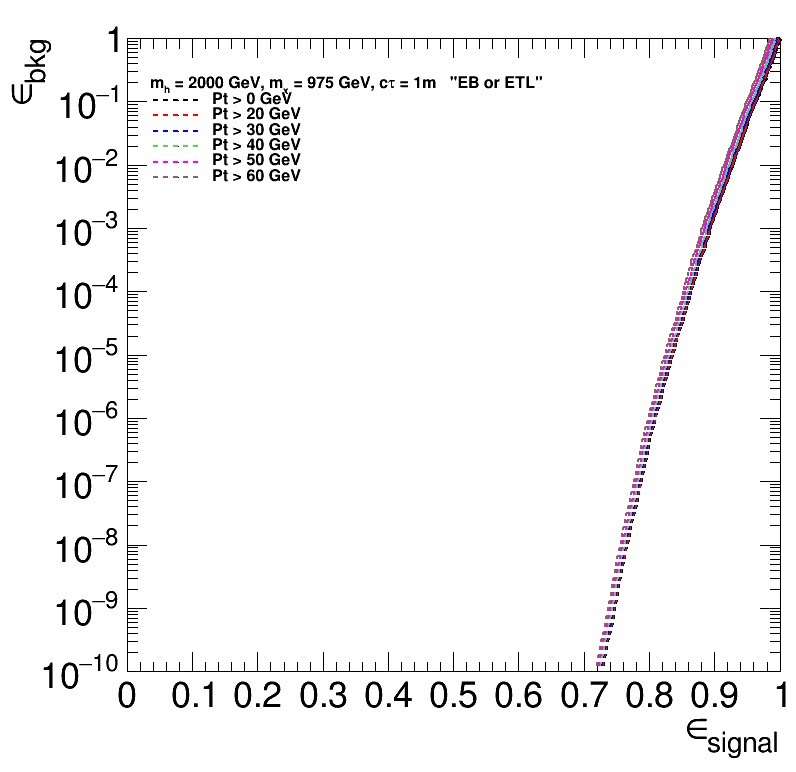

In [53]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
            c = rt.TCanvas('c','c', 800, 800)
            leg = rt.TLegend(0.18,0.76,0.53,0.90)
            leg.SetTextSize(0.022)
            leg.SetBorderSize(0)
            leg.SetFillStyle(0)
            leg.SetEntrySeparation(0.01)            
            leg.SetHeader(texs[k]+'   "'+case+'"')            
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_2j[a].SetLineWidth(2)
                gr_2j[a].SetLineStyle(7)
                gr_2j[a].SetLineColor(std_color_list[p])
                
                if p==0:
#                     print(rej,eff_1j[a])
                    gr_2j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_2j[a].GetXaxis().SetLimits(0,1)
                    gr_2j[a].Draw('ac')
                    leg.AddEntry(gr_2j[a],'Pt > '+str(pt)+' GeV')            
                else:
                    gr_2j[a].Draw('csame')
                    leg.AddEntry(gr_2j[a],'Pt > '+str(pt)+' GeV')            
                    
            leg.Draw()

            c.SetLogy()
            c.Update()
            c.Draw()
            c.SaveAs(out_dir+'Roc_'+k+'_'+case.replace(' ','_')+'_2j.png')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
    i += 1

# leg.Draw()

# c.SetLogy()
# c.Update()
# c.Draw()
# c.SaveAs(out_dir+'Roc_.png')

i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl1000_EB_only_1j2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl1000_ETL_only_1j2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl1000_EB_or_ETL_1j2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_bbbb_ggh_mh125_mx50_pl10000_EB_only_1j2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file

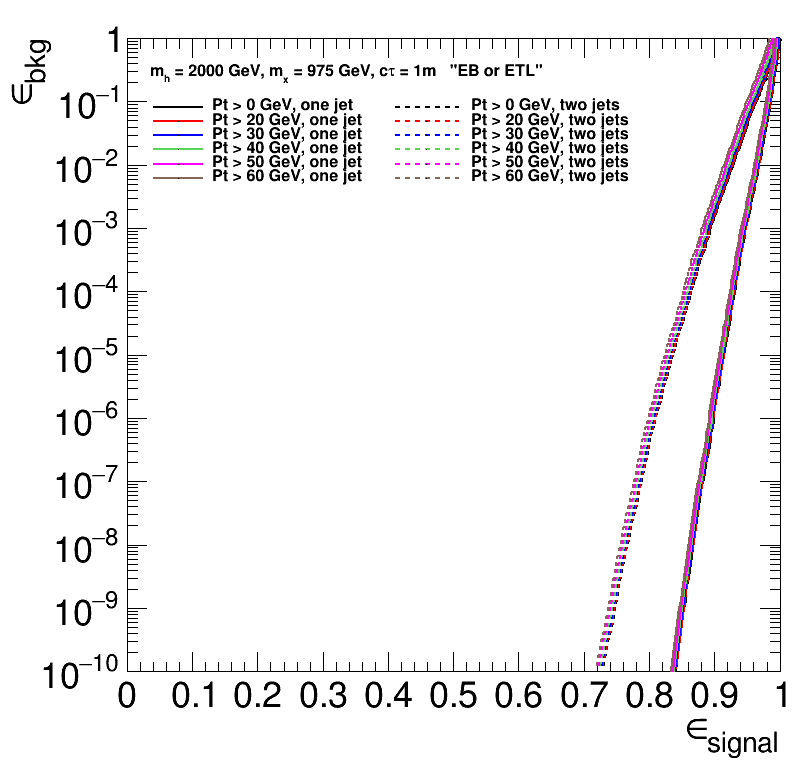

In [54]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
leg1 = rt.TLegend(0.58,0.76,0.93,0.94)
leg1.SetTextSize(0.022)
leg1.SetBorderSize(0)
leg1.SetEntrySeparation(0.01)

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
            c = rt.TCanvas('c','c', 800, 800)
            leg = rt.TLegend(0.18,0.85,0.53,0.96)
            leg.SetTextSize(0.022)
            leg.SetBorderSize(0)
            leg.SetFillStyle(0)
            leg.SetEntrySeparation(0.01)            
            leg.SetHeader(texs[k]+'   "'+case+'"')
            
            leg1 = rt.TLegend(0.48,0.76,0.93,0.87)
            leg1.SetTextSize(0.022)
            leg1.SetFillStyle(0)
            leg1.SetBorderSize(0)
            leg1.SetEntrySeparation(0.01)
            
            leg2 = rt.TLegend(0.18,0.76,0.53,0.87)
            leg2.SetTextSize(0.022)
            leg2.SetBorderSize(0)
            leg2.SetFillStyle(0)
            leg2.SetEntrySeparation(0.01)            
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[p])
                
                gr_2j[a].SetLineWidth(2)
                gr_2j[a].SetLineStyle(7)
                gr_2j[a].SetLineColor(std_color_list[p])
                
                if p==0:
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
                    gr_2j[a].Draw('csame')
                    leg2.AddEntry(gr_1j[a],'Pt > '+str(pt)+' GeV, one jet')            
                    leg1.AddEntry(gr_2j[a],'Pt > '+str(pt)+' GeV, two jets')            
                else:
                    gr_1j[a].Draw('csame')
                    gr_2j[a].Draw('csame')
                    leg2.AddEntry(gr_1j[a],'Pt > '+str(pt)+' GeV, one jet')            
                    leg1.AddEntry(gr_2j[a],'Pt > '+str(pt)+' GeV, two jets')            
                    
            leg.Draw()
            leg2.Draw()
            leg1.Draw()

            c.SetLogy()
            c.Update()
            c.Draw()
            c.SaveAs(out_dir+'Roc_'+k+'_'+case.replace(' ','_')+'_1j2j.png')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
    i += 1

# leg.Draw()

# c.SetLogy()
# c.Update()
# c.Draw()
# c.SaveAs(out_dir+'Roc_.png')

i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt0_EB_only_1j2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt20_EB_only_1j2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt30_EB_only_1j2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt40_EB_only_1j2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt50_EB_only_1j2j.png has been created
Warning in <

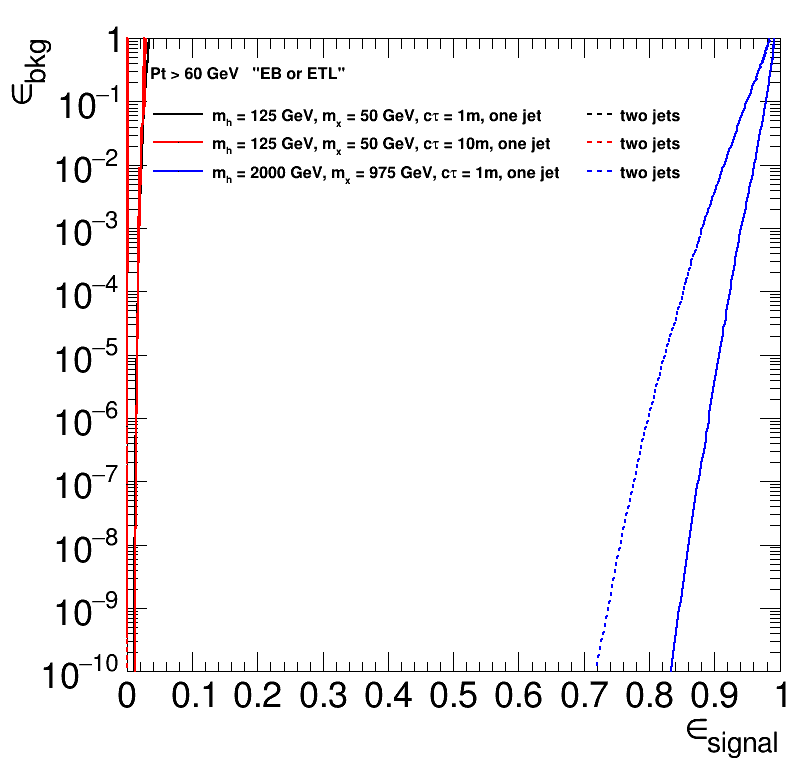

In [61]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
leg1 = rt.TLegend(0.58,0.76,0.93,0.94)
leg1.SetTextSize(0.022)
leg1.SetBorderSize(0)
leg1.SetEntrySeparation(0.01)

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

# for k,v in tree.items(): 
#     print(k,v,i)

for case_i,case in enumerate(cases):
#         print(case_i,i)

    for j,sig in enumerate(sigma):
#             print(j,sig)

#             print(i, j, n, s, m)

        for p,pt in enumerate(pt_cuts):
        
            c = rt.TCanvas('c','c', 800, 800)
            leg = rt.TLegend(0.18,0.85,0.53,0.96)
            leg.SetTextSize(0.022)
            leg.SetBorderSize(0)
            leg.SetFillStyle(0)
            leg.SetEntrySeparation(0.01)            
            leg.SetHeader('Pt > '+str(pt)+' GeV   "'+case+'"')

            leg1 = rt.TLegend(0.73,0.76,0.93,0.87)
            leg1.SetTextSize(0.022)
            leg1.SetFillStyle(0)
            leg1.SetBorderSize(0)
            leg1.SetEntrySeparation(0.01)

            leg2 = rt.TLegend(0.18,0.76,0.53,0.87)
            leg2.SetTextSize(0.022)
            leg2.SetBorderSize(0)
            leg2.SetFillStyle(0)
            leg2.SetEntrySeparation(0.01)            

            
            i = 0
                
            for k,v in tree.items(): 
                
                n = i*len(sigma)+j
                s = case_i*len(sigma)+j
                m = i*len(sigma)*len(cases)+case_i*len(sigma)+j

                
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[i])
                
                gr_2j[a].SetLineWidth(2)
                gr_2j[a].SetLineStyle(7)
                gr_2j[a].SetLineColor(std_color_list[i])
                
                if i==0:
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
                    gr_2j[a].Draw('csame')
                    leg2.AddEntry(gr_1j[a],texs[k]+', one jet')            
                    leg1.AddEntry(gr_2j[a],'two jets')            
                else:
                    gr_1j[a].Draw('csame')
                    gr_2j[a].Draw('csame')
                    leg2.AddEntry(gr_1j[a],texs[k]+', one jet')            
                    leg1.AddEntry(gr_2j[a],'two jets')            

                i += 1
                    
            leg.Draw()
            leg2.Draw()
            leg1.Draw()

            c.SetLogy()
            c.Update()
            c.Draw()
            c.SaveAs(out_dir+'Roc_Pt'+str(pt)+'_'+case.replace(' ','_')+'_1j2j.png')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')

# leg.Draw()

# c.SetLogy()
# c.Update()
# c.Draw()
# c.SaveAs(out_dir+'Roc_.png')

i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt0_EB_only_1j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt20_EB_only_1j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt30_EB_only_1j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt40_EB_only_1j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt50_EB_only_1j.png has been created
Warning in <TCanvas::C

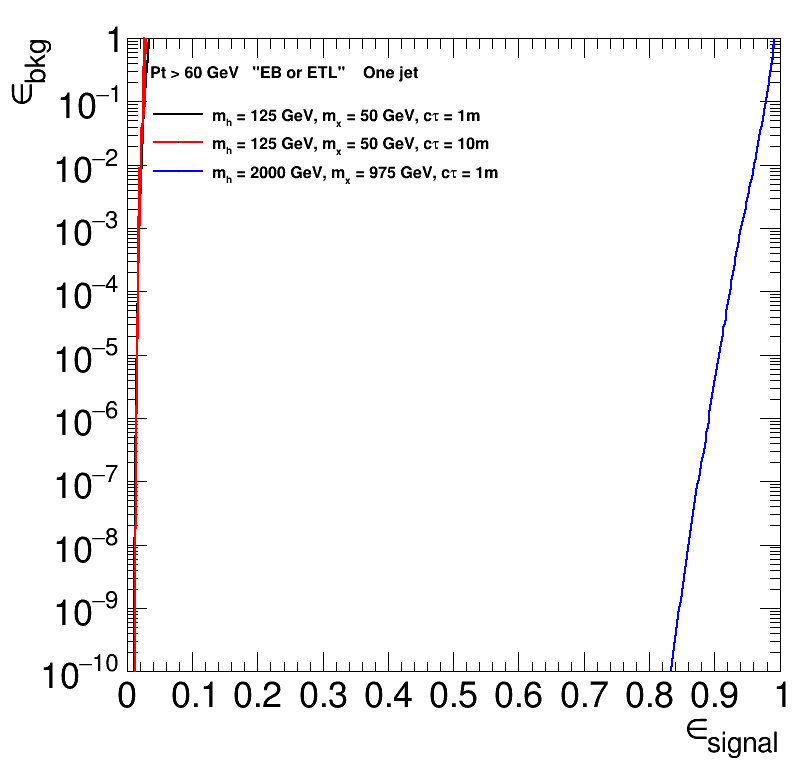

In [66]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
leg1 = rt.TLegend(0.58,0.76,0.93,0.94)
leg1.SetTextSize(0.022)
leg1.SetBorderSize(0)
leg1.SetEntrySeparation(0.01)

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

# for k,v in tree.items(): 
#     print(k,v,i)

for case_i,case in enumerate(cases):
#         print(case_i,i)

    for j,sig in enumerate(sigma):
#             print(j,sig)

#             print(i, j, n, s, m)

        for p,pt in enumerate(pt_cuts):
        
            c = rt.TCanvas('c','c', 800, 800)
            leg = rt.TLegend(0.18,0.85,0.53,0.96)
            leg.SetTextSize(0.022)
            leg.SetBorderSize(0)
            leg.SetFillStyle(0)
            leg.SetEntrySeparation(0.01)            
            leg.SetHeader('Pt > '+str(pt)+' GeV   "'+case+'"    One jet')

            leg1 = rt.TLegend(0.73,0.76,0.93,0.87)
            leg1.SetTextSize(0.022)
            leg1.SetFillStyle(0)
            leg1.SetBorderSize(0)
            leg1.SetEntrySeparation(0.01)

            leg2 = rt.TLegend(0.18,0.76,0.53,0.87)
            leg2.SetTextSize(0.022)
            leg2.SetBorderSize(0)
            leg2.SetFillStyle(0)
            leg2.SetEntrySeparation(0.01)            

            
            i = 0
                
            for k,v in tree.items(): 
                
                n = i*len(sigma)+j
                s = case_i*len(sigma)+j
                m = i*len(sigma)*len(cases)+case_i*len(sigma)+j

                
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[i])
                
                gr_2j[a].SetLineWidth(2)
                gr_2j[a].SetLineStyle(7)
                gr_2j[a].SetLineColor(std_color_list[i])
                
                if i==0:
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
#                     gr_2j[a].Draw('csame')
                    leg2.AddEntry(gr_1j[a],texs[k])            
#                     leg1.AddEntry(gr_2j[a],'two jets')            
                else:
                    gr_1j[a].Draw('csame')
#                     gr_2j[a].Draw('csame')
                    leg2.AddEntry(gr_1j[a],texs[k])            
#                     leg1.AddEntry(gr_2j[a],'two jets')            

                i += 1
                    
            leg.Draw()
            leg2.Draw()
#             leg1.Draw()

            c.SetLogy()
            c.Update()
            c.Draw()
            c.SaveAs(out_dir+'Roc_Pt'+str(pt)+'_'+case.replace(' ','_')+'_1j.png')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')

# leg.Draw()

# c.SetLogy()
# c.Update()
# c.Draw()
# c.SaveAs(out_dir+'Roc_.png')

i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt0_EB_only_2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt20_EB_only_2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt30_EB_only_2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt40_EB_only_2j.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_Pt50_EB_only_2j.png has been created
Warning in <TCanvas::C

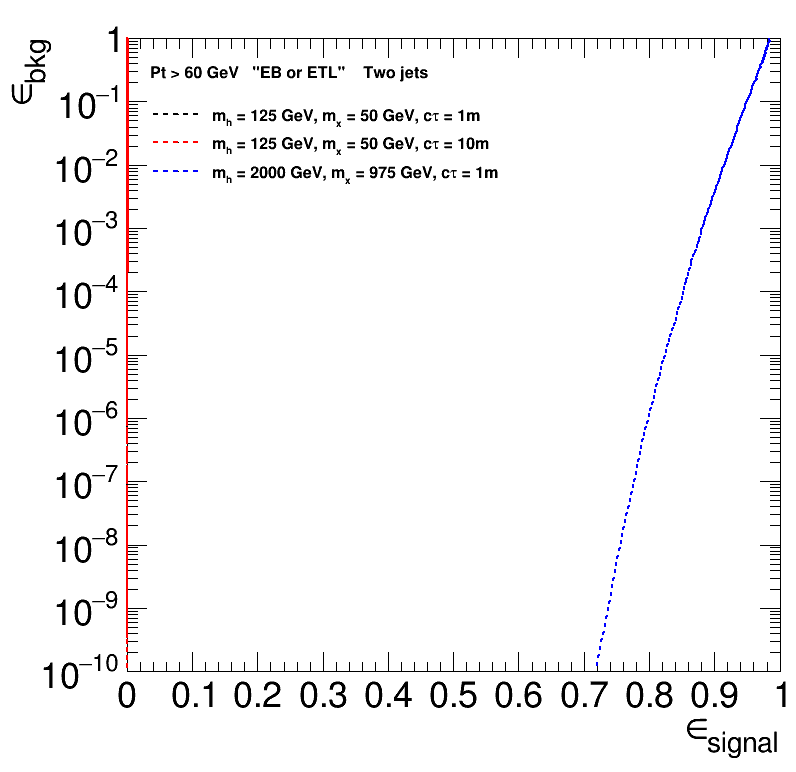

In [65]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
leg1 = rt.TLegend(0.58,0.76,0.93,0.94)
leg1.SetTextSize(0.022)
leg1.SetBorderSize(0)
leg1.SetEntrySeparation(0.01)

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

# for k,v in tree.items(): 
#     print(k,v,i)

for case_i,case in enumerate(cases):
#         print(case_i,i)

    for j,sig in enumerate(sigma):
#             print(j,sig)

#             print(i, j, n, s, m)

        for p,pt in enumerate(pt_cuts):
        
            c = rt.TCanvas('c','c', 800, 800)
            leg = rt.TLegend(0.18,0.85,0.53,0.96)
            leg.SetTextSize(0.022)
            leg.SetBorderSize(0)
            leg.SetFillStyle(0)
            leg.SetEntrySeparation(0.01)            
            leg.SetHeader('Pt > '+str(pt)+' GeV   "'+case+'"    Two jets')

            leg1 = rt.TLegend(0.73,0.76,0.93,0.87)
            leg1.SetTextSize(0.022)
            leg1.SetFillStyle(0)
            leg1.SetBorderSize(0)
            leg1.SetEntrySeparation(0.01)

            leg2 = rt.TLegend(0.18,0.76,0.53,0.87)
            leg2.SetTextSize(0.022)
            leg2.SetBorderSize(0)
            leg2.SetFillStyle(0)
            leg2.SetEntrySeparation(0.01)            

            
            i = 0
                
            for k,v in tree.items(): 
                
                n = i*len(sigma)+j
                s = case_i*len(sigma)+j
                m = i*len(sigma)*len(cases)+case_i*len(sigma)+j

                
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[i])
                
                gr_2j[a].SetLineWidth(2)
                gr_2j[a].SetLineStyle(7)
                gr_2j[a].SetLineColor(std_color_list[i])
                
                if i==0:
#                     print(rej,eff_1j[a])
                    gr_2j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_2j[a].GetXaxis().SetLimits(0,1)
#                     gr_1j[a].Draw('ac')
                    gr_2j[a].Draw('ac')
                    leg2.AddEntry(gr_2j[a],texs[k])            
#                     leg1.AddEntry(gr_2j[a],'two jets')            
                else:
                    gr_2j[a].Draw('csame')
#                     gr_2j[a].Draw('csame')
                    leg2.AddEntry(gr_2j[a],texs[k])            
#                     leg1.AddEntry(gr_2j[a],'two jets')            

                i += 1
                    
            leg.Draw()
            leg2.Draw()
#             leg1.Draw()

            c.SetLogy()
            c.Update()
            c.Draw()
            c.SaveAs(out_dir+'Roc_Pt'+str(pt)+'_'+case.replace(' ','_')+'_2j.png')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')
#                 gr_1j[a].Draw('ac' if i==0 else 'c')

# leg.Draw()

# c.SetLogy()
# c.Update()
# c.Draw()
# c.SaveAs(out_dir+'Roc_.png')

i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_0_Pt0_1j.png has been created


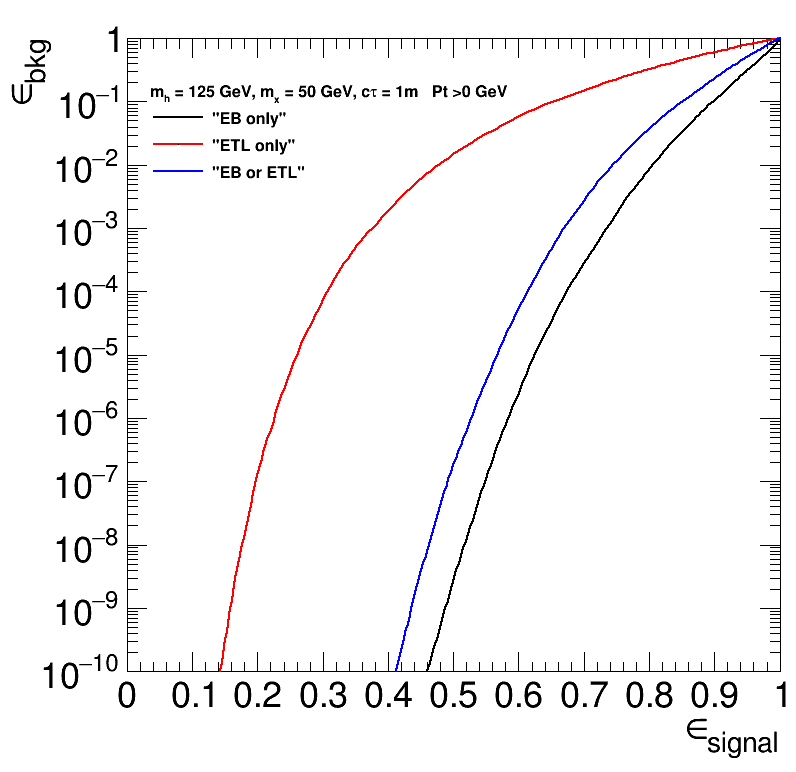

In [19]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)            

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

            
    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
   
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[case_i])
                
                
                
                if i==0 and case_i==0 and p==0:
                    leg.SetHeader(texs[k]+'   Pt >'+str(pt)+' GeV')         
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                elif i==0 and p==0:
                    gr_1j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                    


    i += 1

leg.Draw()

c.SetLogy()
c.Update()
c.Draw()


i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_1_Pt0_1j.png has been created


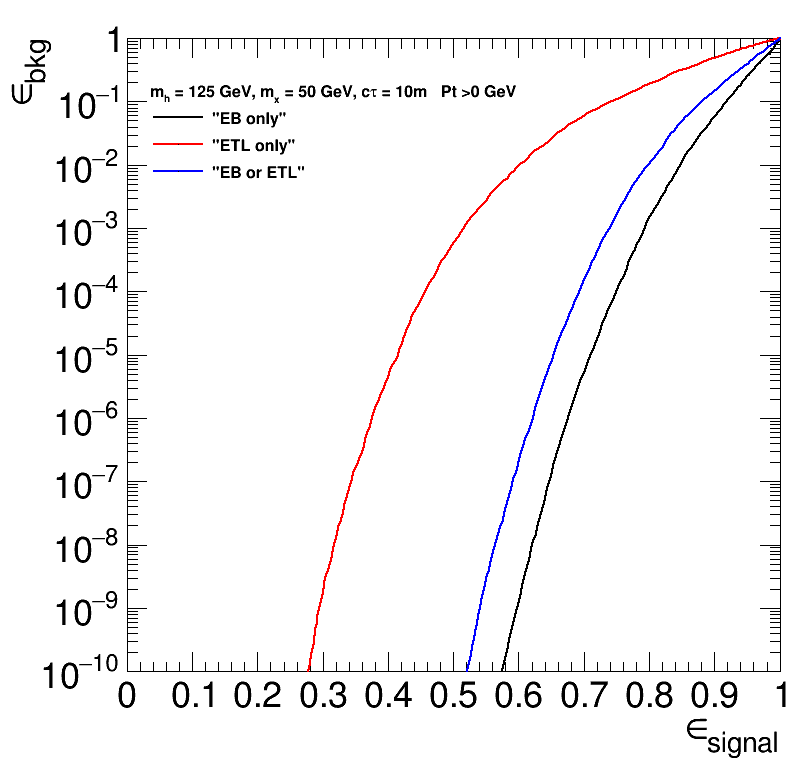

In [20]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)            

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

            
    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
   
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[case_i])
                
                
                
                if i==1 and case_i==0 and p==0:
                    leg.SetHeader(texs[k]+'   Pt >'+str(pt)+' GeV')         
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                elif i==1 and p==0:
                    gr_1j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                    


    i += 1

leg.Draw()

c.SetLogy()
c.Update()
c.Draw()


i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_2_Pt0_1j.png has been created


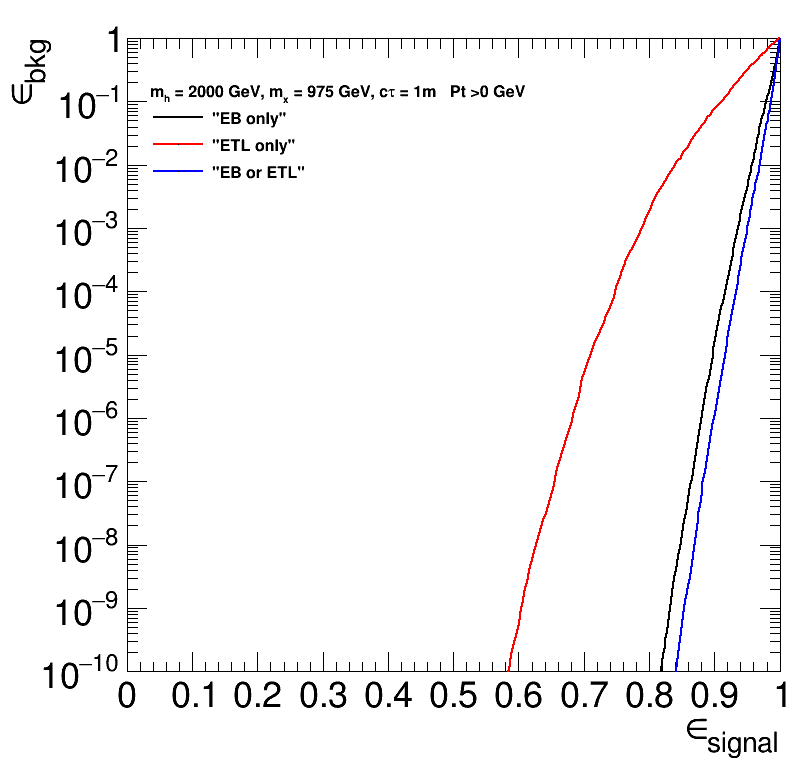

In [21]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)            

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

            
    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
   
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[case_i])
                
                
                
                if i==2 and case_i==0 and p==0:
                    leg.SetHeader(texs[k]+'   Pt >'+str(pt)+' GeV')         
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                elif i==2 and p==0:
                    gr_1j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                    


    i += 1

leg.Draw()

c.SetLogy()
c.Update()
c.Draw()


i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_2_Pt20_1j.png has been created


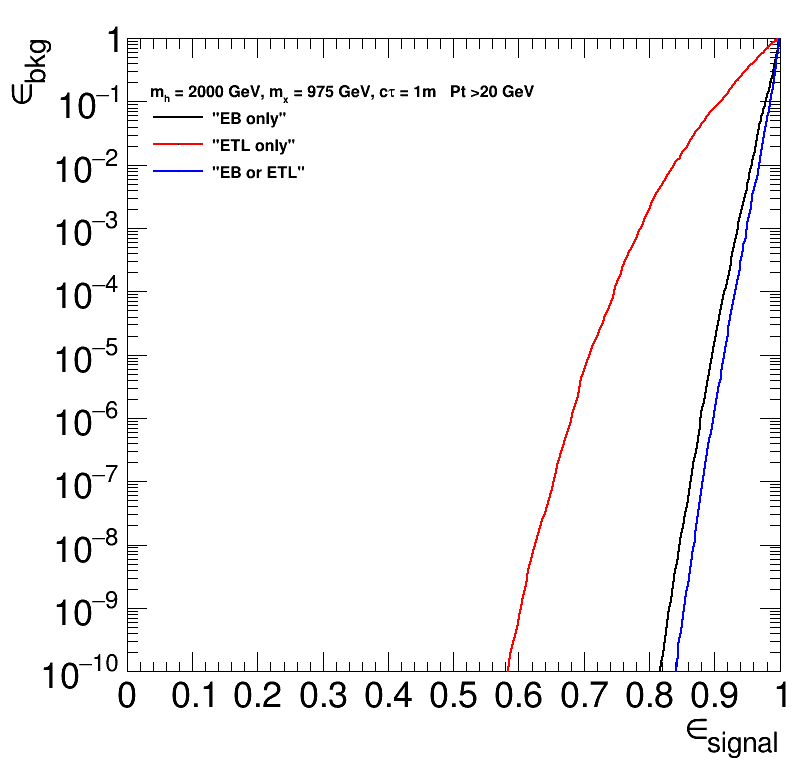

In [22]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)            

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

            
    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
   
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[case_i])
                
                
                
                if i==2 and case_i==0 and p==1:
                    leg.SetHeader(texs[k]+'   Pt >'+str(pt)+' GeV')         
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                elif i==2 and p==1:
                    gr_1j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                    


    i += 1

leg.Draw()

c.SetLogy()
c.Update()
c.Draw()


i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_1_Pt20_1j.png has been created


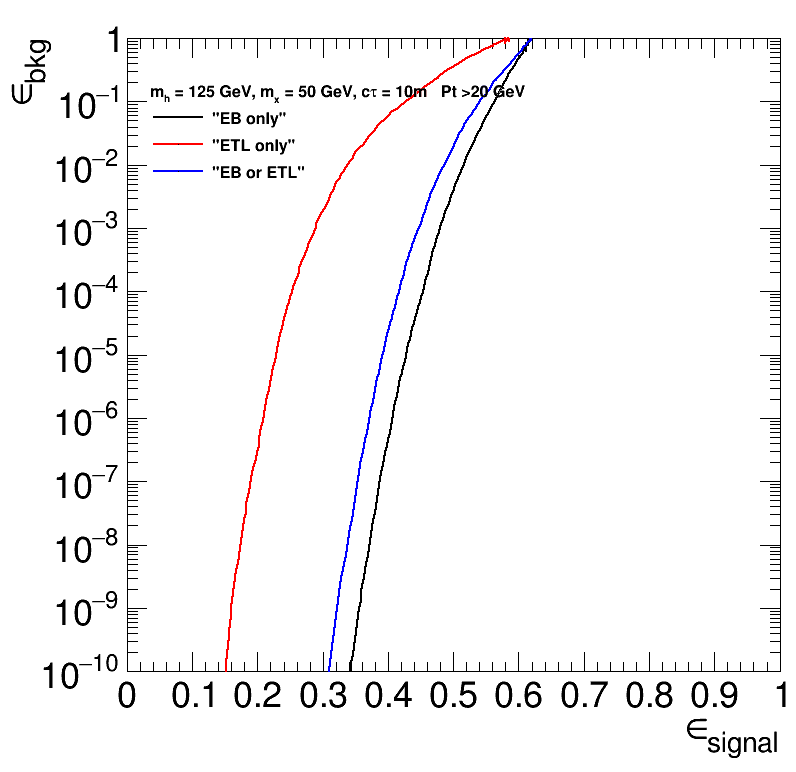

In [23]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)            

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

            
    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
   
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[case_i])
                
                
                
                if i==1 and case_i==0 and p==1:
                    leg.SetHeader(texs[k]+'   Pt >'+str(pt)+' GeV')         
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_1j[a].Draw('ac')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                elif i==1 and p==1:
                    gr_1j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"')            
                    


    i += 1

leg.Draw()

c.SetLogy()
c.Update()
c.Draw()


i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_1_Pt20_2j.png has been created


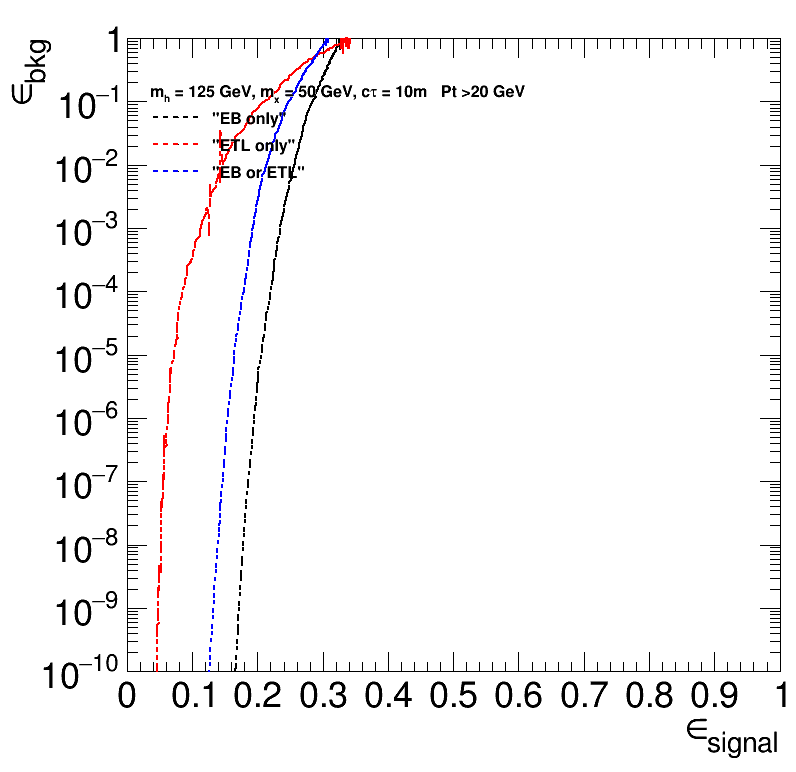

In [24]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)            

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

            
    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
   
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_2j[a].SetLineWidth(2)
                gr_2j[a].SetLineStyle(7)
                gr_2j[a].SetLineColor(std_color_list[case_i])
                
                
                
                if i==1 and case_i==0 and p==1:
                    leg.SetHeader(texs[k]+'   Pt >'+str(pt)+' GeV')         
#                     print(rej,eff_1j[a])
                    gr_2j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_2j[a].GetXaxis().SetLimits(0,1)
                    gr_2j[a].Draw('ac')
                    leg.AddEntry(gr_2j[a],'"'+case+'"')            
                elif i==1 and p==1:
                    gr_2j[a].Draw('csame')
                    leg.AddEntry(gr_2j[a],'"'+case+'"')            
                    


    i += 1

leg.Draw()

c.SetLogy()
c.Update()
c.Draw()


i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_1_Pt20_1j2j.png has been created


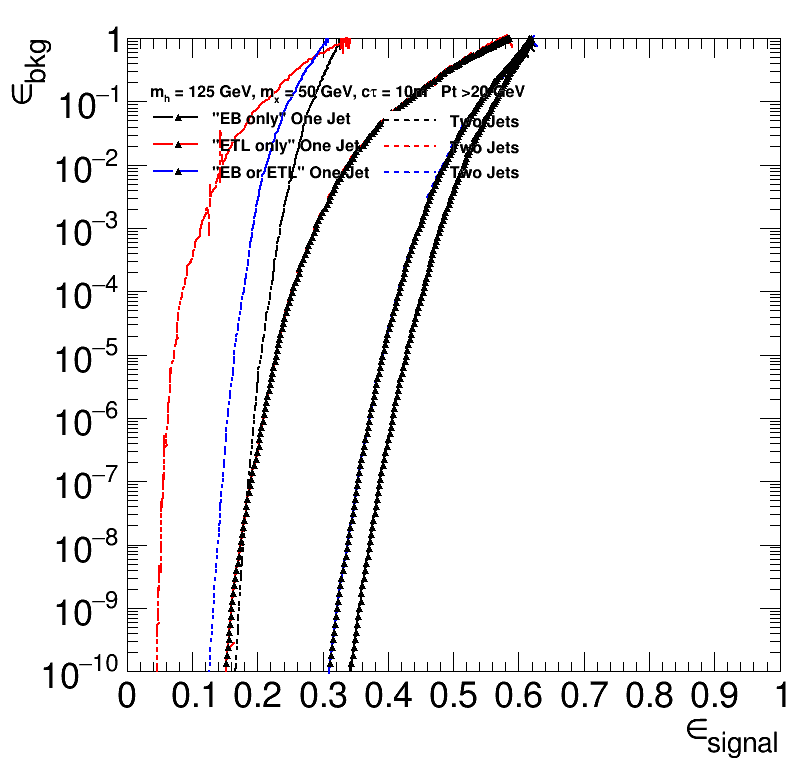

In [25]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)   

leg1 = rt.TLegend(0.47,0.76,0.83,0.86)
leg1.SetTextSize(0.022)
leg1.SetBorderSize(0)
leg1.SetFillStyle(0)
leg1.SetEntrySeparation(0.01)       

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

            
    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
   
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineStyle(9)
                gr_1j[a].SetMarkerStyle(22)
                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[case_i])
                
                gr_2j[a].SetLineWidth(2)
                gr_2j[a].SetLineStyle(7)
                gr_2j[a].SetLineColor(std_color_list[case_i])               
                
                
                
                if i==1 and case_i==0 and p==1:
#                     leg.SetHeader(texs[k])         
#                     leg1.SetHeader('   Pt >'+str(pt)+' GeV')         
                    leg.SetHeader(texs[k]+'   Pt >'+str(pt)+' GeV')         
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_2j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_2j[a].GetXaxis().SetLimits(0,1)
        
                    gr_1j[a].Draw('acp')
                    gr_2j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"'+' One Jet')            
                    leg1.AddEntry(gr_2j[a], ' Two Jets')            
#                     leg1.AddEntry(gr_2j[a],'"'+case+'"'+' Two Jets')            
                elif i==1 and p==1:
                    gr_1j[a].Draw('cpsame')
                    gr_2j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"'+' One Jet')            
                    leg1.AddEntry(gr_2j[a], ' Two Jets')            
#                     leg1.AddEntry(gr_2j[a],'"'+case+'"'+' Two Jets')            
                    


    i += 1

leg.Draw()
leg1.Draw()

c.SetLogy()
c.Update()
c.Draw()


i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_2_Pt20_1j2j.png has been created


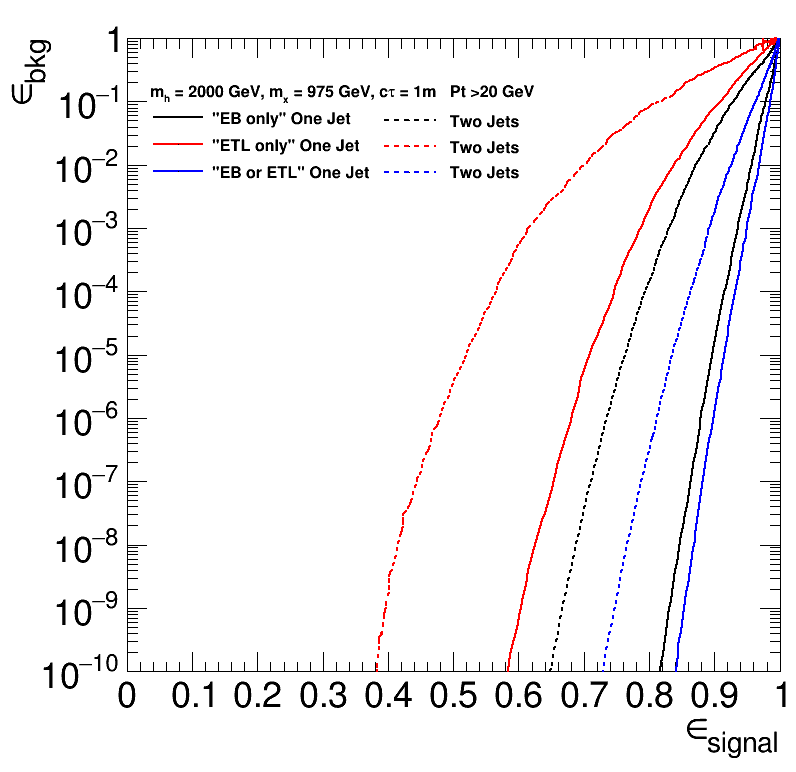

In [26]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)   

leg1 = rt.TLegend(0.47,0.76,0.83,0.86)
leg1.SetTextSize(0.022)
leg1.SetBorderSize(0)
leg1.SetFillStyle(0)
leg1.SetEntrySeparation(0.01)       

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

            
    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
   
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[case_i])
                
                gr_2j[a].SetLineWidth(2)
                gr_2j[a].SetLineStyle(7)
                gr_2j[a].SetLineColor(std_color_list[case_i])               
                
                
                
                if i==2 and case_i==0 and p==1:
#                     leg.SetHeader(texs[k])         
#                     leg1.SetHeader('   Pt >'+str(pt)+' GeV')         
                    leg.SetHeader(texs[k]+'   Pt >'+str(pt)+' GeV')         
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_2j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_2j[a].GetXaxis().SetLimits(0,1)
        
                    gr_1j[a].Draw('ac')
                    gr_2j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"'+' One Jet')            
                    leg1.AddEntry(gr_2j[a], ' Two Jets')            
#                     leg1.AddEntry(gr_2j[a],'"'+case+'"'+' Two Jets')            
                elif i==2 and p==1:
                    gr_1j[a].Draw('csame')
                    gr_2j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"'+' One Jet')            
                    leg1.AddEntry(gr_2j[a], ' Two Jets')            
#                     leg1.AddEntry(gr_2j[a],'"'+case+'"'+' Two Jets')            
                    


    i += 1

leg.Draw()
leg1.Draw()

c.SetLogy()
c.Update()
c.Draw()


i,j,n,s,m,a


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190719/Roc_0_Pt20_1j2j.png has been created


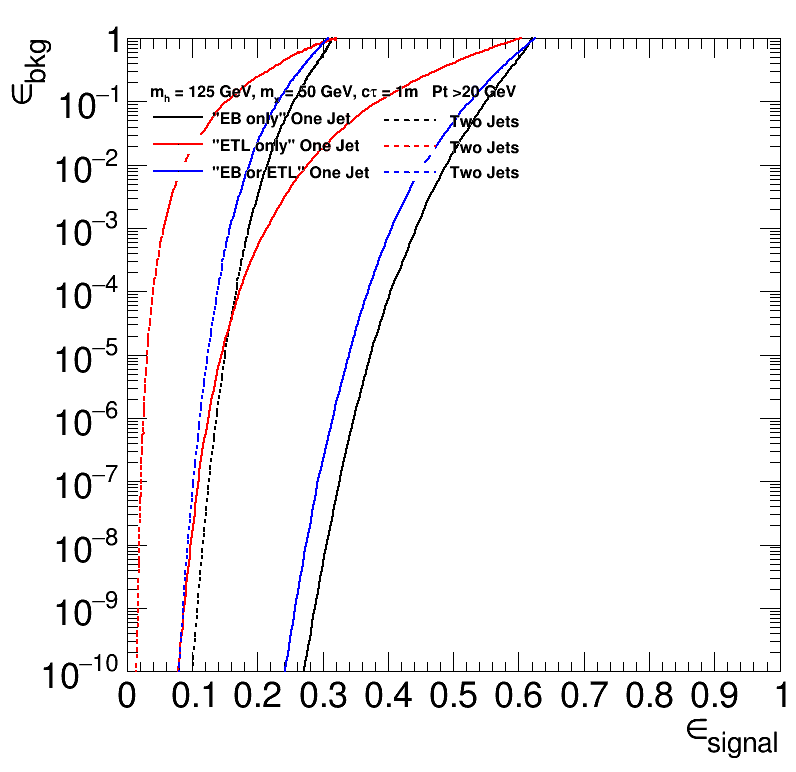

In [27]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.18,0.76,0.53,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetEntrySeparation(0.01)   

leg1 = rt.TLegend(0.47,0.76,0.83,0.86)
leg1.SetTextSize(0.022)
leg1.SetBorderSize(0)
leg1.SetFillStyle(0)
leg1.SetEntrySeparation(0.01)       

gr_1j = {}
gr_2j = {}

i = 0

print('i,j,n,s,m,a')

for k,v in tree.items(): 
#     print(k,v,i)

            
    for case_i,case in enumerate(cases):
#         print(case_i,i)
        
        for j,sig in enumerate(sigma):
#             print(j,sig)
            n = i*len(sigma)+j
            s = case_i*len(sigma)+j
            m = i*len(sigma)*len(cases)+case_i*len(sigma)+j
            
#             print(i, j, n, s, m)
   
            
            for p,pt in enumerate(pt_cuts):
#                 print(p,pt)
                a = i*len(sigma)*len(cases)*len(pt_cuts)+case_i*len(sigma)*len(pt_cuts)+j*len(sigma)+p
#                 print(i,j,n,s,m,a)
        
                gr_1j[a] = create_TGraph(eff_1j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                gr_2j[a] = create_TGraph(eff_2j[a], rej, axis_title = ['#epsilon_{signal}','#epsilon_{bkg}'])
                


                gr_1j[a].SetLineWidth(2)
                gr_1j[a].SetLineColor(std_color_list[case_i])
                
                gr_2j[a].SetLineWidth(2)
                gr_2j[a].SetLineStyle(7)
                gr_2j[a].SetLineColor(std_color_list[case_i])               
                
                
                
                if i==0 and case_i==0 and p==1:
#                     leg.SetHeader(texs[k])         
#                     leg1.SetHeader('   Pt >'+str(pt)+' GeV')         
                    leg.SetHeader(texs[k]+'   Pt >'+str(pt)+' GeV')         
#                     print(rej,eff_1j[a])
                    gr_1j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_1j[a].GetXaxis().SetLimits(0,1)
                    gr_2j[a].GetYaxis().SetRangeUser(1e-10,1)
                    gr_2j[a].GetXaxis().SetLimits(0,1)
        
                    gr_1j[a].Draw('ac')
                    gr_2j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"'+' One Jet')            
                    leg1.AddEntry(gr_2j[a], ' Two Jets')            
#                     leg1.AddEntry(gr_2j[a],'"'+case+'"'+' Two Jets')            
                elif i==0 and p==1:
                    gr_1j[a].Draw('csame')
                    gr_2j[a].Draw('csame')
                    leg.AddEntry(gr_1j[a],'"'+case+'"'+' One Jet')            
                    leg1.AddEntry(gr_2j[a], ' Two Jets')            
#                     leg1.AddEntry(gr_2j[a],'"'+case+'"'+' Two Jets')            
                    


    i += 1

leg.Draw()
leg1.Draw()

c.SetLogy()
c.Update()
c.Draw()


# Normal distribution

In [38]:
import scipy.stats
scipy.stats.norm(0, 1)
scipy.stats.norm(0, 1).pdf(0)


0.3989422804014327

In [80]:
scipy.stats.norm.sf(0,0,1)

0.5

In [39]:
scipy.stats.norm(0, 1).cdf(0)

0.5

In [40]:
scipy.stats.norm(0, 1).cdf(0.6)

0.7257468822499265

In [42]:
import scipy.stats
scipy.stats.norm(loc=100, scale=12)
#where loc is the mean and scale is the std dev
#if you wish to pull out a random number from your distribution
scipy.stats.norm.rvs(loc=100, scale=12)

104.69388017206356

In [43]:
#To find the probability that the variable has a value LESS than or equal
#let's say 113, you'd use CDF cumulative Density Function
scipy.stats.norm.cdf(113,100,12)

0.8606697525503779

In [ ]:
Output: 0.86066975255037792
#or 86.07% probability

In [46]:
#To find the probability that the variable has a value GREATER than or
#equal to let's say 125, you'd use SF Survival Function 
scipy.stats.norm.sf(113,100,12)

0.13933024744962208

In [47]:
scipy.stats.norm.cdf(113,100,12)+scipy.stats.norm.sf(113,100,12)

1.0

In [44]:
#To find the probability that the variable has a value GREATER than or
#equal to let's say 125, you'd use SF Survival Function 
scipy.stats.norm.sf(125,100,12)

0.018610425189886332

In [ ]:
Output: 0.018610425189886332
#or 1.86%

In [49]:
#To find the variate for which the probability is given, let's say the 
#value which needed to provide a 98% probability, you'd use the 
#PPF Percent Point Function
scipy.stats.norm.ppf(.86,100,12)

112.96383208977947

In [45]:
#To find the variate for which the probability is given, let's say the 
#value which needed to provide a 98% probability, you'd use the 
#PPF Percent Point Function
scipy.stats.norm.ppf(.98,100,12)

124.64498692758187

In [41]:
Output: 124.64498692758187